In [1]:
import matplotlib.pyplot as plt
import cv2
import torch.nn as N
from torchinfo import summary
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms.v2 import Compose, Resize, ToImage, ToDtype
import pandas as pd
from torcheval.metrics import MulticlassAccuracy
from torchvision.models import resnet50, ResNet50_Weights
from IPython.display import clear_output
import math
import numpy as np

## Hyper params.

In [2]:
batchSize = 16
inChannels = 3
inputDims = (batchSize, inChannels, 256, 256)
patchDims = (2, 2)
maxSeqLen = 128

resnetOutputChannels = 1024
resnetOutputDims = (inputDims[-2]//16, inputDims[-1]//16)
numPatches = (resnetOutputDims[0] * resnetOutputDims[1]) // (patchDims[0] * patchDims[1])

ffDim = 1024
nHeads = 4
nLayers = 4
dropout = 0.1

epochs = 5
lr = 9e-5

vocabSize = -1
transforms = [Resize((inputDims[-2], inputDims[-1]))]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
INPUT_PARENT_DIR = "/repos/pytorch-basics/datasets/crohme/IMG/"
GROUND_TRUTH_DIR = "/repos/pytorch-basics/datasets/crohme/groundtruth/"
VOCAB_FILE = "/repos/pytorch-basics/datasets/crohme/groundtruth/symbols.txt"
MODEL_SAVEFILE_PATH = "./models/MathEqGen.pt"

### Custom tokenizer

In [4]:
class CustomTokenizer():
	def __init__(self, vocabFile, maxSeqLen, start_token, end_token, pad_token, unk_token):
		self.vocab: dict = {}
		self.reverseVocab: dict = {}
		self.unk_token = unk_token
		self.start_token = start_token
		self.end_token = end_token
		self.pad_token = pad_token
		self.maxSeqLen = maxSeqLen
		
		i = 0
		with open(vocabFile, 'r') as f:
			for line in f.readlines():
				self.vocab[line.strip("\n")] = i
				self.reverseVocab[i] = line.strip("\n")
				i += 1
	
	def tokenize(self, input: str) -> list[str] :
		wordsInVocab = list(self.vocab.keys())
		tokens = []
		i = 0
		while i < len(input):
			match_found = False
			# Try to match the longest possible symbol in the vocabulary
			for symbol in sorted(wordsInVocab, key=len, reverse=True):
				if input[i:i+len(symbol)] == symbol:
					tokens.append(symbol)
					i += len(symbol)
					match_found = True
					break
			if not match_found:
				tokens.append(self.unk_token)
				i += 1
		tokens = [self.start_token] + tokens + [self.end_token]
		return tokens
	
	def tokensToIds(self, tokens: list[str]) -> list[int] :
		idsList = []
		for token in tokens:
			idsList.append(self.vocab[token])
		
		return idsList
	
	def padTokens(self, tokens: list[str]) -> list[str]:		
		tokensLength = len(tokens)
		if(tokensLength > self.maxSeqLen):
			return tokens[:self.maxSeqLen - 1] + [self.end_token]

		tokens = tokens + [self.pad_token] * (self.maxSeqLen - tokensLength)
		return tokens
	
	def idsToTokens(self, ids: list[int]) -> list[str] :
		tokens = []
		for id in ids:
			token = self.reverseVocab[id]
			tokens.append(token)

		return tokens
	
	def getVocabSize(self) -> int :
		return len(self.vocab)

### Dataset class

In [5]:
class CROHMEDataset(Dataset):
	def __init__(self, mode, transforms, tokenizer):
		super(CROHMEDataset, self).__init__()
		self.transforms = transforms
		groundTruthFile: str = GROUND_TRUTH_DIR + mode + ".csv"
		self.files: pd.DataFrame = pd.read_csv(groundTruthFile)
		self.tokenizer = tokenizer

	def __len__(self):
		return self.files.shape[0]
	
	def __getitem__(self, index):
		inputPath, groundTruth = self.files.iloc[index]
		inputPath = inputPath.removesuffix(".inkml") + ".png"

		groundTruth: str = groundTruth.strip('"').replace("{", "\\{").replace("}", "\\}")
		equation = groundTruth

		image = cv2.imread(INPUT_PARENT_DIR + inputPath, cv2.IMREAD_UNCHANGED)
		if len(image.shape) == 2:
			image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

		input = Compose([ToImage(), ToDtype(torch.float32, scale=True)])(image)
		
		for transform in self.transforms:
			input = transform(input)

		groundTruthTokens = self.tokenizer.tokenize(groundTruth)
		groundTruthTokens = self.tokenizer.padTokens(groundTruthTokens)
		groundTruthIds = self.tokenizer.tokensToIds(groundTruthTokens)
		groundTruthIds = torch.LongTensor(groundTruthIds)

		# eq. and inputPath are also returned for debugging purposes
		return (input, groundTruthIds, equation, inputPath)

### Dataloader

In [6]:
tokenizer = CustomTokenizer(VOCAB_FILE, maxSeqLen, "[SOS]", "[EOS]", "[PAD]", "[UNK]")
vocabSize = tokenizer.getVocabSize()

trainData = CROHMEDataset('train', transforms, tokenizer)
testData = CROHMEDataset('test', transforms, tokenizer)
valData = CROHMEDataset('val', transforms, tokenizer)

trainDataLoader = DataLoader(trainData, batch_size= batchSize
							 , shuffle= True, drop_last= True)
testDataLoader = DataLoader(testData, batch_size= 1
							 , shuffle= True, drop_last= True)
# valDataLoader = DataLoader(valData, batch_size= batchSize
# 							 , shuffle= True, drop_last= True)

### Feature extractor

In [7]:
class FeatureExtractor(N.Module):
	def __init__(self, featExOutputChannels, ffDim, patchDims):
		super(FeatureExtractor, self).__init__()
		self.featEx = N.Sequential(*(list(
						resnet50(ResNet50_Weights.IMAGENET1K_V2).children()
					)[0:-3]))
		self.convProj = N.Conv2d(in_channels= featExOutputChannels, out_channels= ffDim,
						   		 kernel_size= patchDims, stride= patchDims)

		for param in self.featEx.parameters():
			param.requires_grad = False

	def forward(self, input):
		features = self.featEx(input)
		output: torch.Tensor = self.convProj(features)
		return output.flatten(2,3)

### Vision encoder

In [8]:
class VisionEncoder(N.Module):
	def __init__(self, numPatches: int, 
			  batchSize: int, dModel: int, nLayers: int,
			  nHeads: int, dropout: int= 0.1):
		super(VisionEncoder, self).__init__()
		encoderLayer = N.TransformerEncoderLayer(d_model= dModel, nhead= nHeads,
										   dim_feedforward= ffDim, dropout= dropout,
										   batch_first= True)
		
		self.posEmb = N.Parameter(torch.zeros(1,
										dModel, numPatches))
		self.transformerEncoder = N.TransformerEncoder(encoder_layer= encoderLayer, 
												 num_layers= nLayers)
	def forward(self, input):
		embs = input + self.posEmb
		output = self.transformerEncoder(embs.transpose(1,2))

		return output

### Decoder

In [9]:
class Decoder(N.Module):
	class PositionalEmbedding(N.Module):
		def __init__(self, dModel):
			super().__init__()
			self.dModel = dModel

		def forward(self, input):
			emb = math.log(10000) / (self.dModel // 2 - 1)
			emb = torch.exp(torch.arange(self.dModel // 2) * -emb)
			emb = input[:, None] * emb[None, :]
			emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
			return emb

	def __init__(self, dModel: int, nHeads: int, nLayers: int, 
			  ffDim: int, maxSeqLen: int, dropout: int= 0.1):
		super(Decoder, self).__init__()
		decoderLayer = N.TransformerDecoderLayer(d_model= dModel, nhead= nHeads,
										   dim_feedforward= ffDim, dropout= dropout,
										   batch_first= True)
		
		self.transformerDecoder = N.TransformerDecoder(decoder_layer= decoderLayer,
												 num_layers= nLayers)
		self.embeddings = N.Embedding(num_embeddings= maxSeqLen, embedding_dim= dModel)
		self.posEmb = self.PositionalEmbedding(dModel= dModel)

	def forward(self, tgt, encOutput, tgt_padding_mask= None, mode= "train"):		
		tgtEmbs = self.embeddings(tgt)
		bs, l, h = tgtEmbs.shape

		seqIdx = torch.arange(l)
		posEmb = self.posEmb(seqIdx).reshape(1, l, h).expand(bs, l, h).cuda()
		embs = tgtEmbs + posEmb

		causalMask = torch.triu(torch.ones(l, l), 1).bool().cuda()
		
		if(mode == "debug"):
			print(f"embs.shape: {embs.shape}")
		
		output = self.transformerDecoder(tgt= embs, memory= encOutput,
								   		 tgt_mask= causalMask, 
										 tgt_key_padding_mask= tgt_padding_mask)
		
		return output

### Model definition

In [10]:
class Model(N.Module):
	def __init__(self, patchDims: tuple, batchSize: int, 
			  	 nHeads: int, nLayers: int, ffDim: int, 
			  	 dModel: int, numPatches: int, maxSeqLen: int,
				 vocabSize: int = -1, dropout: float = 0.1):
		super(Model, self).__init__()

		if(vocabSize <= 1):
			raise ValueError(f"Invalid vocabulary size; Must be greater than 1, got {vocabSize}")

		self.featEx = FeatureExtractor(dModel, ffDim, patchDims)
		self.visEnc = VisionEncoder(numPatches, batchSize, dModel,
							  		nLayers, nHeads, dropout)
		self.decoder = Decoder(dModel, nHeads, nLayers,
						 	   ffDim, maxSeqLen, dropout)
		self.fcOut = N.Linear(dModel, vocabSize)
		self.softmax = N.Softmax(dim= -1)

	def forward(self, src, tgt, tgt_padding_mask, mode= "train"):
		featExOutput = self.featEx(src)
		visEncOutput = self.visEnc(featExOutput)
		
		if(mode == "debug"):
			print(f"tgt.shape: {tgt.shape}, visEncOutput.shape: {visEncOutput.shape}")
		
		decoderOutput = self.decoder(tgt, visEncOutput, tgt_padding_mask, mode)
		output = self.fcOut(decoderOutput)
		# output = self.softmax(output)

		return output


### Model instantiation

In [11]:
model = Model(patchDims= patchDims, batchSize= batchSize,
			  nHeads= nHeads, nLayers= nLayers, ffDim= ffDim, 
			  dModel= resnetOutputChannels, numPatches= numPatches, 
			  maxSeqLen= maxSeqLen, vocabSize= vocabSize,
			  dropout= dropout)
model.to(device= device)

/home/home-pc/miniconda3/envs/pytorch-basics/lib/python3.12/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


Model(
  (featEx): FeatureExtractor(
    (featEx): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
     

In [12]:
summary(
    model,
    input_data=[
        torch.zeros(inputDims).to(device),  # src
        torch.zeros((batchSize, maxSeqLen), dtype=torch.int64).to(device),  # tgt
        torch.zeros((batchSize, maxSeqLen), dtype=torch.bool).to(device)   # tgt_padding_mask
    ],
    col_names=['input_size', 'output_size', 'num_params', 'trainable'],
    row_settings=['var_names'],
    verbose=0
)

Layer (type (var_name))                                           Input Shape               Output Shape              Param #                   Trainable
Model (Model)                                                     [16, 3, 256, 256]         [16, 128, 113]            --                        Partial
├─FeatureExtractor (featEx)                                       [16, 3, 256, 256]         [16, 1024, 64]            --                        Partial
│    └─Sequential (featEx)                                        [16, 3, 256, 256]         [16, 1024, 16, 16]        --                        False
│    │    └─Conv2d (0)                                            [16, 3, 256, 256]         [16, 64, 128, 128]        (9,408)                   False
│    │    └─BatchNorm2d (1)                                       [16, 64, 128, 128]        [16, 64, 128, 128]        (128)                     False
│    │    └─ReLU (2)                                              [16, 64, 128, 128]        

### Training loop

In [13]:
def generate_padding_mask(tgt, padTokenIdx = 0) -> torch.Tensor:
	return (tgt == padTokenIdx)

In [14]:
opt = torch.optim.Adam(model.parameters(), lr= lr)
loss_fn = N.CrossEntropyLoss(ignore_index= tokenizer.vocab['[PAD]'])
mca = MulticlassAccuracy()

lr_schedule = {
	3 : 7e-5,
	6 : 5e-5,
	9 : 3e-5
}

for epoch in range(epochs):

	if(epoch in lr_schedule.keys()):
		for g in opt.param_groups:
			g['lr'] = lr_schedule[epoch]

	clear_output(wait= True)
	print(f"Starting epoch {epoch + 1} of {epochs}\n~~~~~~~~~~~~~~~~~~~~~~~~~")

	trainLoss = 0
	trainAcc = 0

	for idx, (src, tgt, eq, file) in enumerate(trainDataLoader):
		currBatchAcc = 0.

		src, token_ids = src.cuda(), tgt.cuda()
		padding_mask = generate_padding_mask(tgt, tokenizer.vocab['[PAD]']).cuda()

		target_ids = torch.cat([token_ids[:,1:], 
						  torch.zeros(batchSize,1, device= device).long()], 1)
		
		preds = model(src, token_ids, tgt_padding_mask= padding_mask)

		loss = loss_fn(preds.view(-1, vocabSize), target_ids.view(-1))

		opt.zero_grad()
		loss.backward()
		opt.step()

		for i in range(batchSize):
			eos_token_idx = (token_ids[i] == tokenizer.vocab['[EOS]']).nonzero().item()
			mca.update(preds[i, : eos_token_idx].argmax(dim= -1), token_ids[i, 1 : eos_token_idx + 1])
			currBatchAcc += mca.compute()
		
		currBatchLoss = loss.detach().item()
		currBatchAcc /= batchSize

		trainLoss += currBatchLoss
		trainAcc += currBatchAcc

		if(idx % 100 == 0):
			print(f"Batch: {idx}; Loss: {currBatchLoss:0.5f}; Acc.: {currBatchAcc * 100:0.2f}%")

	trainLoss /= len(trainDataLoader)
	trainAcc /= len(trainDataLoader)
	print(f"Epoch: {epoch + 1}; Avg loss: {trainLoss:0.5f}; Avg acc.: {trainAcc * 100:0.2f}%")

Starting epoch 5 of 5
~~~~~~~~~~~~~~~~~~~~~~~~~
Batch: 0; Loss: 0.70173; Acc.: 67.87%
Batch: 100; Loss: 0.57740; Acc.: 68.16%
Batch: 200; Loss: 0.69336; Acc.: 68.44%
Batch: 300; Loss: 0.86009; Acc.: 68.67%
Batch: 400; Loss: 0.96605; Acc.: 68.90%
Batch: 500; Loss: 0.73565; Acc.: 69.07%
Batch: 600; Loss: 0.97800; Acc.: 69.32%
Batch: 700; Loss: 0.75101; Acc.: 69.51%
Epoch: 5; Avg loss: 0.87458; Avg acc.: 68.81%


### Testing

In [31]:
import itertools
sample_idx = 15

test_src, test_tgt, test_eq, test_file = next(itertools.islice(testDataLoader,
                                                    sample_idx, None))

test_input_tokens = torch.Tensor([[tokenizer.vocab['[SOS]']] +
								 [tokenizer.vocab['[PAD]']] * (maxSeqLen - 1)] * 1).long().cuda()
generated_eq = []

model.eval()

with torch.inference_mode():
	test_src = test_src.cuda()
	
	for i in range(maxSeqLen):
		test_padding_mask = generate_padding_mask(test_input_tokens).cuda()
		test_preds = model(test_src, test_input_tokens, test_padding_mask)
		test_pred_tokens = test_preds[0,i].argmax(dim= -1)

		generated_eq.append(test_pred_tokens.item())
		if(test_pred_tokens.item() == tokenizer.vocab['[EOS]']):
			break
		test_input_tokens[:,i+1] = test_pred_tokens.view(-1)
		


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.21706706..1.0000002].


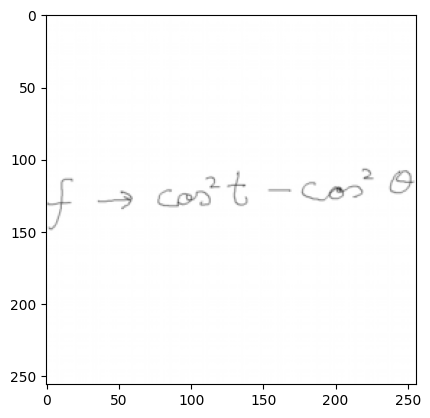

In [32]:
foo: np.ndarray = test_src[0].cpu().numpy()
foo = foo.transpose(1,2,0)
plt.imshow(foo)
plt.show()

In [33]:
test_tgt[0]

tensor([ 81, 109,  87, 111,  70, 111,  44, 110,  11, 111,  78, 101,  79, 111,
          6, 111,  44, 110,  11, 111,  78,  76,  79, 109, 112,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0])

In [34]:
test_eq

('$f \\rightarrow \\cos^2 \\{t\\} - \\cos^2 \\{\\theta\\}$',)

In [35]:
torch.Tensor(generated_eq).long()

tensor([109, 105, 111,  19, 111,  49,  78,   6,  83, 111,  68, 111,  73,  78,
         83, 110,  11, 111,   6,  13,  82,  84,  79,  79,  78,  11,  82,  79,
        109, 112])

In [36]:
generated_tokens = tokenizer.idsToTokens(generated_eq)[:-1]
eq_str = ""
for token in generated_tokens:
	eq_str = eq_str + token
print(eq_str)

$x = \frac\{-b \pm \sqrt\{b^2 -4ac\}\}\{2a\}$


In [22]:
torch.save(model, MODEL_SAVEFILE_PATH)